# Analyzing Virginia Woolf's Texts Through Semantic Analysis
KAELA OLSEN, Cornell University, English & Information Science<br>
<br> 
December 19, 2020<br>
ENGL 3520: Virginia Woolf<br> 

## Introduction
Virginia Woolf is one of English Literature's most famed novelists, with good reason. However, a common discourse surrounding many of her novels is tailored towards the evasive emotions that weave themselves throughout her work. 

Through the use of text-mining and data analysis, this project hopes to paint an alternate picture of the emotions that illuminate and illustrate the worlds Woolf creates; to quantitatively visualize the fluctuation of emotions within her characters, her worlds, and her ideas.

## Research Questions:
This research study analyzes the sentences, and words, that Woolf uses to construct her novels, in hopes to further investigate the role of positive and negative emotion in her work. By interpreting the mood of her texts' sentences and words, we can illustrate how emotion changes throughout each text. Does, for example, Between the Acts grow "sadder" or "happier", as we near the novel's end? Will our quantitative analysis of a novel's emotion match up with our qualitative analysis? What might our results show us about how "truthful" our subjective intuitions are about the emotions that underlay each of Woolf's most notable novels?

Will the data give us the answers? Don't want to suggest that exactly. 
If data doesn't match our sense, could be because we aren't testing the right things.
Finding differences could cause us to think more critically, help refine the machine learning models.

## Data Description
The data used for this sentiment analysis was web-scrabed from online e-books proveded by the Project Gutenberg Australia, which provides free ebooks by authors who died before 1955. Using BeautifulSoup to process each webpage, I extracted the text from each site, which was often correlated which a respective text by Woolf. 

After extracting the text, I processed it into sentences through a text-mining function written below. Upon separating the text into sentences (which proved more complicated than anticipated!), I created a dataframe for each text, which each row an individual sentence. Then, with a dataframe made for each of Woolf's text, I was ready to perform some exciting analyses!

## Data Processing: Web-Scraping

In [42]:
import re
#import string
#import sys
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score
#from collections import Counter

Below, I create a function which extracts the relevant text from the webpage urls. This function uses requests to pull the content from the url, then BeautifulSoup parses through the HTML to access the page's text. Then, it removes any text in extraneous headings, footers, tables, etc., and returns one massive string of text.

In [2]:
def text_from_url(url):
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    
    output = ''
    blacklist = ['[document]','a','b','big','blockquote','body','center','font','h1','h2','head','html','i','pre','style','table','td','title','tr']

    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
    
    return output

As an example, we can see what the function text_from_url might output after pulling the text off of the Gutenberg webpage for <em>Mrs. Dalloway</em>, one of Woolf's most notable novels:

In [3]:
mrs_dalloway_url = 'http://gutenberg.net.au/ebooks02/0200991h.html'
mrs_dalloway = text_from_url(mrs_dalloway_url)
mrs_dalloway 

'\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 Mrs. Dalloway said she would buy the flowers herself. For Lucy had her work cut out for her. The doors would be taken\r\noff their hinges; Rumpelmayer\'s men were coming. And then, thought\r\nClarissa Dalloway, what a morning--fresh as if issued to children on\r\na beach. What a lark! What a plunge! For so it had always seemed to her,\r\nwhen, with a little squeak of the hinges, which she could hear now,\r\nshe had burst open the French windows and plunged at Bourton into the\r\nopen air. How fresh, how calm, stiller than this of course, the air\r\nwas in the early morning; like the flap of a wave; the kiss of a\r\nwave; chill and sharp and yet (for a girl of eighteen as she then\r\nwas) solemn, feeling as she did, standing there at the open window,\r\nthat something awful was about to happen; looking at the flowers, at\r\nthe trees with the smoke winding off them and the rooks rising,\r\nfalling; standing and looking until Peter Walsh said, "Mu

While we were able to succeessfully pull out all of the text we are interested in, we caught a decent amount of gibberish as well! The \r\n's represent line breaks in the text on the webpage. Now, we have to create a function that will allow us to parse through this complicated jumble of characters, and pull out a clean list of sentences instead.

In [4]:
alphabets = "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"

def extract_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = text.replace("\r","")
    text = re.sub(prefixes,"\\1<prd>",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace("\ ", "")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

The function above takes the huge clump of text from above, sorts through character by character, and replaces, or removes, any letters or symbols we don't want. There are quite a bit of hoops this function jumps over; it must successfully discern sentence breaks from words like "Dr.", "Inc.", and even understand what to do with quotations that indicate new speakers. 

We can see how successful our function is at pulling apart the different sentences by employing the same example as above.

In [5]:
mrs_dalloway_sentence_list = extract_sentences(mrs_dalloway)
mrs_dalloway_sentence_list

['Mrs. Dalloway said she would buy the flowers herself.',
 'For Lucy had her work cut out for her.',
 "The doors would be taken off their hinges; Rumpelmayer's men were coming.",
 'And then, thought Clarissa Dalloway, what a morning--fresh as if issued to children on a beach.',
 'What a lark!',
 'What a plunge!',
 'For so it had always seemed to her, when, with a little squeak of the hinges, which she could hear now, she had burst open the French windows and plunged at Bourton into the open air.',
 'How fresh, how calm, stiller than this of course, the air was in the early morning; like the flap of a wave; the kiss of a wave; chill and sharp and yet (for a girl of eighteen as she then was) solemn, feeling as she did, standing there at the open window, that something awful was about to happen; looking at the flowers, at the trees with the smoke winding off them and the rooks rising, falling; standing and looking until Peter Walsh said, "Musing among the vegetables"?',
 '--was that it?',

Success! From glancing the initial output above, the function appears to have provided a nice, clean list of each sentence in Mrs. Dalloway. However, there is not much data analysis one can do from a list, and its much easier to work with a dataframe. Thus, we can turn this list into a handy dataframe via a package called pandas.

In [6]:
mrs_dalloway_sentence_df = pd.DataFrame(mrs_dalloway_sentence_list).rename(columns={0: 'sentence'})
mrs_dalloway_sentence_df

,sentence
0,Mrs. Dalloway said she would buy the flowers h...
1,For Lucy had her work cut out for her.
2,The doors would be taken off their hinges; Rum...
3,"And then, thought Clarissa Dalloway, what a mo..."
4,What a lark!
...,...
3709,what is this ecstasy?
3710,he thought to himself.
3711,What is it that fills me with extraordinary ex...
3712,"It is Clarissa, he said."


From slotting all the sentences into a dataframe, we can get better handle on the data. Previewing the dataframe shows us the first five and last five sentences of the book, which all checks out. As shown by the 3714 rows, there are 3714 sentences in Mrs. Dalloway. The last sentence, "For there she was", reads even more powerfully when alone in it's own dataframe cell! 

Now, we have a sturdy process in place for extracting each publication's text off of the Gutenberg website, processing the extraction, and polishing it off into sentences. However, its a tedious process, especially if we hope to redo it multiple times for a dozen or so Woolf works. Let's streamline this entire process into one function that starts with the webpage url, and returns the ready-to-use dataframe.

In [7]:
def url_to_df(url):
    text = text_from_url(url)
    sentences = extract_sentences(text)
    df = pd.DataFrame(sentences).rename(columns={0: 'sentence'})
    return df

While we might have jumped one hurdle, we have been faced with another. Only about half of Woolf's texs, provided by Project Gutenberg, are on HTML pages. The rest are on TXT pages (as indicated by the '.txt' at the end of the webpage URL). For .txt webpages, using requests to pull the page's contents gives us the entire chunk of text directly. Thus, we can store the text and run the same extract_sentences function to parse through the text for each sentence, and then pull it all together into a dataframe like we did before. The function below does exactly this.

In [8]:
def txt_to_df(txt):
    response = requests.get(txt)
    data = response.text
    sentences = extract_sentences(data)
    df = pd.DataFrame(sentences).rename(columns={0: 'sentence'})
    return df

With these two functions, we can populate new dataframes for the rest of Woolf's works that we would like to analyze. This research will look at the following texts by Woolf:
#### Breakdown on Genre:
<em>Novels:</em>
- Voyage Out, 1915
- Night and Day, 1919
- Jacob's Room, 1922
- Mrs. Dalloway, 1925
- To the Lighthouse, 1927
- Between the Acts, 1941

<em>Essays:</em>
- Modern Fiction, 1921
- Mr. Bennett and Mrs. Brown, 1923
- A Room of One's Own, 1929
- Three Guineas, 1938

<em>Short Stories:</em>
- Mark On the Wall, 1917
- Kew Gardens, 1919
- Street Haunting, 1930

<em>Biographies:</em>
- Orlando, 1928
- Flush, 1933

Onto the data processing!

## Creating DataFrames for Each Publication

As you'll see below, each publication has its own webpage (aside from the short stories, which sometimes share a page). The functions we created above, url_to_df and txt_to_df, successfully create sentence dataframes for us. 

Unfortunately, there were a few websites with tricky formatting for the texts' headings and subheadings, especially with the .txt webpages. This produced some dataframes where the first few rows of sentences were things like 'VIRGINIA WOOLF PUBLISHED BY LEONARD AND VIRGINIA WOOLF  AT THE HOGARTH PRESS TAVISTOCK SQUARE  LONDON W.C.I 1924 MR.'. Thus, I had to remove these wonky rows through '.iloc[]' and then reset the index for the dataframe. Through a little manipulation, we escape with some clean datasets!

In [9]:
# Voyage Out
voyage_out_url = 'http://gutenberg.net.au/ebooks/m00020.txt'
voyage_out = txt_to_df(voyage_out_url)
voyage_out['sentence'][0] = voyage_out['sentence'][0].replace('Project Gutenberg Australia    THE VOYAGE OUT (1915) by Virginia Woolf (1882-1941)    Chapter I   ', '', 1)
voyage_out

,sentence
0,As the streets that lead from the Strand to th...
1,"If you persist, lawyers' clerks will have to m..."
2,In the streets of London where beauty goes unr...
3,One afternoon in the beginning of October when...
4,Angry glances struck upon their backs.
...,...
8399,Pepper beaten at last?
8400,"I congratulate you""!"
8401,"said Arthur Venning, who was wheeling old Mrs...."
8402,All these voices sounded gratefully in St. Joh...


In [10]:
# Bennett Brown
bennett_brown_url = 'http://www.gutenberg.org/files/63022/63022-h/63022-h.htm'
bennett_brown = url_to_df(bennett_brown_url).iloc[2:].reset_index(drop=True)
bennett_brown['sentence'][0] = bennett_brown['sentence'][0].replace('BROWN ', '', 1)
bennett_brown

,sentence
0,"It seems to me possible, perhaps desirable, th..."
1,"And when I asked myself, as your invitation to..."
2,"Catch me if you can""."
3,Most novelists have the same experience.
4,"Some Brown, Smith, or Jones comes before them ..."
...,...
376,"Tolerate the spasmodic, the obscure, the fragm..."
377,Your help is invoked in a good cause.
378,For I will make one final and surpassingly ras...
379,But it can only be reached if we are determine...


In [11]:
# Flush
flush_url = 'http://gutenberg.net.au/ebooks03/0301041h.html'
flush = url_to_df(flush_url)
flush

,sentence
0,It is universally admitted that the family fro...
1,Therefore it is not strange that the origin of...
2,Many million years ago the country which is no...
3,Ages passed; vegetation appeared; where there ...
4,There is nothing in this that calls for questi...
...,...
2148,"[10] ""he was now dead""."
2149,It is certain that Flush died; but the date an...
2150,The only reference consists in the statement t...
2151,Mrs. Browning was buried in the English Cemete...


In [12]:
# Mrs. Dalloway
mrs_dalloway_url = 'http://gutenberg.net.au/ebooks02/0200991h.html'
mrs_dalloway = url_to_df(mrs_dalloway_url)
mrs_dalloway 

,sentence
0,Mrs. Dalloway said she would buy the flowers h...
1,For Lucy had her work cut out for her.
2,The doors would be taken off their hinges; Rum...
3,"And then, thought Clarissa Dalloway, what a mo..."
4,What a lark!
...,...
3709,what is this ecstasy?
3710,he thought to himself.
3711,What is it that fills me with extraordinary ex...
3712,"It is Clarissa, he said."


In [13]:
# To the Lighthouse
to_the_lighthouse_url = 'http://gutenberg.net.au/ebooks01/0100101h.html'
to_the_lighthouse = url_to_df(to_the_lighthouse_url)
to_the_lighthouse['sentence'][0] = to_the_lighthouse['sentence'][0].replace('by', '', 1)
to_the_lighthouse

,sentence
0,"""Yes, of course, if it's fine tomorrow,"" said..."
1,"""But you'll have to be up with the lark,"" she ..."
2,To her son these words conveyed an extraordina...
3,"Since he belonged, even at the age of six, to ..."
4,It was fringed with joy.
...,...
3510,"she asked herself, taking up her brush again."
3511,She looked at the steps; they were empty; she ...
3512,"With a sudden intensity, as if she saw it clea..."
3513,It was done; it was finished.


In [14]:
# Orlando
orlando_url = 'http://gutenberg.net.au/ebooks02/0200331h.html'
orlando = url_to_df(orlando_url).iloc[18:].reset_index(drop=True)
orlando

,sentence
0,"He--for there could be no doubt of his sex, th..."
1,"It was the colour of an old football, and more..."
2,"Orlando's father, or perhaps his grandfather, ..."
3,Orlando's fathers had ridden in fields of asph...
4,"So too would Orlando, he vowed."
...,...
3407,Her pearls burnt like a phosphorescent flare i...
3408,"And as Shelmerdine, now grown a fine sea capta..."
3409,'It is the goose!
3410,' Orlando cried.


In [15]:
# Three Guineas
three_guineas_url = 'http://gutenberg.net.au/ebooks02/0200931h.html'
three_guineas = url_to_df(three_guineas_url)
three_guineas

,sentence
0,Three years is a long time to leave a letter u...
1,"I had hoped that it would answer itself, or th..."
2,But there it is with its question--How in your...
3,--still unanswered.
4,It is true that many answers have suggested th...
...,...
3483,.
3484,Cette individualité n'a par elle seule ni sign...
3485,Elle ne prend un sens quelconque qu'en devenan...
3486,"' ( by George Sand, pp."


In [16]:
# Between the Acts
between_the_acts_url = 'http://gutenberg.net.au/ebooks03/0301171h.html'
between_the_acts = url_to_df(between_the_acts_url)
between_the_acts

,sentence
0,"It was a summer's night and they were talking,..."
1,The county council had promised to bring water...
2,"Mrs. Haines, the wife of the gentleman farmer,..."
3,Then there was silence; and a cow coughed; and...
4,"But, then, as a small child in a perambulator,..."
...,...
4455,The house had lost its shelter.
4456,"It was night before roads were made, or houses."
4457,It was the night that dwellers in caves had wa...
4458,Then the curtain rose.


In [17]:
# Mark on the Wall
mark_on_the_wall_url = 'http://www.gutenberg.org/files/29220/29220-h/29220-h.htm#THE_MARK_ON_THE_WALL'
mark_on_the_wall = url_to_df(mark_on_the_wall_url).iloc[2:].reset_index(drop=True)
mark_on_the_wall

,sentence
0,"From room to room they went, hand in hand, lif..."
1,"""Here we left it,"" she said."
2,"And he added, ""Oh, but here too""!"
3,"""It's upstairs,"" she murmured."
4,"""And in the garden,"" he whispered."
...,...
1167,Nothing ever happens.
1168,Curse this war; God damn this war!
1169,"... All the same, I don't see why we should ha..."
1170,"Ah, the mark on the wall!"


In [18]:
# Night and Day
night_day_url = 'http://gutenberg.net.au/ebooks/m00019.txt'
night_day = txt_to_df(night_day_url)
night_day['sentence'][0] = night_day['sentence'][0].replace('Project Gutenberg Australia    Night and Day by Virginia Woolf   TO VANESSA BELL BUT, LOOKING FOR A PHRASE, I FOUND NONE TO STAND BESIDE YOUR NAME      NIGHT AND DAY    CHAPTER I  ', '', 1)
night_day

,sentence
0,"It was a Sunday evening in October, and in com..."
1,Perhaps a fifth part of her mind was thus occu...
2,"But although she was silent, she was evidently..."
3,A single glance was enough to show that Mrs. H...
4,Considering that the little party had been sea...
...,...
9294,Katharine pushed the door half open and stood ...
9295,The light lay in soft golden grains upon the d...
9296,"For a moment they waited, and then loosed thei..."
9297,"""Good night,"" he breathed."


In [19]:
# A Room of One's Own
room_of_ones_own_url = 'http://gutenberg.net.au/ebooks02/0200791.txt'
room_of_ones_own = txt_to_df(room_of_ones_own_url).iloc[15:].reset_index(drop=True)
room_of_ones_own['sentence'][0] = room_of_ones_own['sentence'][0].replace(']    ONE    ', '', 1)
room_of_ones_own

,sentence
0,au ------------------------------------------...
1,"The papers were too long to be read in full, a..."
2,"] ONE But, you may say, we asked you to ..."
3,I will try to explain.
4,When you asked me to speak about women and fic...
...,...
1585,"This opportunity, as I think, it is now coming..."
1586,For my belief is that if we live another centu...
1587,Drawing her life from the lives of the unknown...
1588,"As for her coming without that preparation, wi..."


In [20]:
# Jacob's Room
jacobs_room_url = 'http://gutenberg.net.au/ebooks/m00018.txt'
jacobs_room = txt_to_df(jacobs_room_url)
jacobs_room['sentence'][0] = jacobs_room['sentence'][0].strip('Project Gutenberg Australia    Jacob\'s Room by Virginia Woolf     CHAPTER ONE   ')
jacobs_room

,sentence
0,"""So of course,"" wrote Betty Flanders, pressing..."
1,"Slowly welling from the point of her gold nib,..."
2,The entire bay quivered; the lighthouse wobble...
3,She winked quickly.
4,Accidents were awful things.
...,...
3431,"""Such confusion everywhere""!"
3432,"exclaimed Betty Flanders, bursting open the be..."
3433,Bonamy turned away from the window.
3434,"""What am I to do with these, Mr. Bonamy""?"


### Handing some difficult cases
There were a handful of texts, particularly the short stories and essays, that were a little harder to extract, as they were placed on a webpage with multiple other texts. Street Haunting is difficult because its halfway down the webpage, which means we have to find a way to jump halfway down the page and start extracting text from there. I deal with them on a case by case basis here, using the .split() function to manually find the location in the text where I'd like to begin extracting.

In [21]:
# Street Haunting
street_haunting_url = 'http://gutenberg.net.au/ebooks02/0200771.txt'
book = requests.get(street_haunting_url).text
x = book.split('STREET HAUNTING: A LONDON ADVENTURE (Written in 1930.)')[1].split('JONES AND WILKINSON(Drawn from the MEMOIRS OF TATE WILKINSON,4 vols.,1790.)')[0]
street_haunting = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})
street_haunting

,sentence
0,No one perhaps has ever felt passionately towa...
1,But there are circumstances in which it can be...
2,As the foxhunter hunts in order to preserve th...
3,The hour should be the evening and the season ...
4,We are not then taunted as in the summer by th...
...,...
195,And what greater delight and wonder can there ...
196,That is true: to escape is the greatest of ple...
197,"Still as we approach our own doorstep again, i..."
198,Here again is the usual door; here the chair t...


In [62]:
# Kew Gardens 
kew_gardens_url = 'http://www.gutenberg.org/files/29220/29220-h/29220-h.htm#KEW_GARDENS'
book = text_from_url(kew_gardens_url)
x = book.split('A wave\r\nrolls beneath the blue bells. But the cathedral\'s different, cold,\r\nincense laden, faint blue with the veils of madonnas.')[1]
kew_gardens = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})[:91].reset_index(drop = True)
kew_gardens

,sentence
0,From the oval-shaped flower-bed there rose per...
1,The petals were voluminous enough to be stirre...
2,"The light fell either upon the smooth, grey ba..."
3,"Instead, the drop was left in a second silver ..."
4,Then the breeze stirred rather more briskly ov...
...,...
86,It seemed as if all gross and heavy bodies had...
87,Voices.
88,"Yes, voices."
89,"Wordless voices, breaking the silence suddenly..."


In [79]:
# Modern Fiction
modern_fiction_url = 'http://gutenberg.net.au/ebooks03/0300031h.html#C12'
book = text_from_url(modern_fiction_url)
x = book.split('confidence in her own success')[1].split('confidence in her own success')[0]
modern_fiction = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})[1:105].reset_index(drop=True)
modern_fiction

,sentence
0,"In making any survey, even the freest and loos..."
1,With their simple tools and primitive material...
2,Their masterpieces certainly have a strange ai...
3,And yet the analogy between literature and the...
4,It is doubtful whether in the course of the ce...
...,...
99,The voice of protest is the voice of another a...
100,English fiction from Sterne to Meredith bears ...
101,But any deductions that we may draw from the c...
102,"""The proper stuff of fiction"" does not exist; ..."


## Making Use of the Data

### Sentiment Analysis with Vader
A method for sentiment analysis is vader(Valence Aware Dictionary and sEntiment Reasoner). According to the authors, it is, “a lexicon and rule-based sentiment analysis tool.” Vader measures both the strength and direction of sentiment. Based on the work of 10 coders, the Vader dictionary includes approximately 7,500 words, emoticons, emojis, acronyms, and commonly used slang.

Vader scores an entire text, not just words. Looking at the whole text allows for the algorithm to adjust for negations, such as “not”, booster words, such as “remarkably”. It also scores words written in all caps as more intense. Vader returns the proportion of a text that is negative, positive, and neutral, along with a combined score.

In [80]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

The polarity_scores method returns a dictionary with four items. pos, neu, and neg are the proportions of text that fall in each category. compound is the normalized, weighted composite score. Vader is useful because it looks at words in context and scores them appropriately, while other methods might only look at singular words, but ignore things like negations or amplifiers that surround that individual word.

In [81]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield.
    Returns scores and original dataframe.'''
    analyzer = SentimentIntensityAnalyzer()
    sentiment = df[textfield].apply(analyzer.polarity_scores)
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

In [82]:
voyage_out_vader = vaderize(voyage_out, 'sentence')
night_day_vader = vaderize(night_day, 'sentence')
room_of_ones_own_vader = vaderize(room_of_ones_own, 'sentence')
mark_on_the_wall_vader = vaderize(mark_on_the_wall, 'sentence')
modern_fiction_vader = vaderize(modern_fiction, 'sentence')
bennett_brown_vader = vaderize(bennett_brown, 'sentence')
flush_vader = vaderize(flush, 'sentence')
jacobs_room_vader = vaderize(jacobs_room, 'sentence')
mrs_dalloway_vader = vaderize(mrs_dalloway, 'sentence')
to_the_lighthouse_vader = vaderize(to_the_lighthouse, 'sentence')
orlando_vader = vaderize(orlando, 'sentence')
three_guineas_vader = vaderize(three_guineas, 'sentence')
between_the_acts_vader = vaderize(between_the_acts, 'sentence')
kew_gardens_vader = vaderize(kew_gardens, 'sentence')
street_haunting_vader = vaderize(street_haunting, 'sentence')

In [83]:
# Breakdown on Genre:
# Novel
    # Voyage Out, 1915-- 'voyage': voyage_out_vader,
    # Night and Day, 1919 --'night': night_day_vader,
    # Jacob's Room, 1922 -- jacobs': jacobs_room_vader,
    # Mrs. Dalloway, 1925 -- 'dalloway': mrs_dalloway_vader,
    # To the Lighthouse, 1927 --'lighthouse': to_the_lighthouse_vader,
    # Between the Acts, 1941 --'bta': between_the_acts_vader

# Short Stories
    # Mark On the Wall, 1917 -- 'mark': mark_on_the_wall_vader,
    # Kew Gardens, 1919 -- n/a
    # Street Haunting, 1930 -- n/a

# Essays / Non-Fiction
    # Modern Fiction, 1921 -- 'modern': modern_fiction_vader,
    # Mr. Bennett and Mrs. Brown, 1923 --'bennett': bennett_brown_vader,
    # A Room of One's Own, 1929 -- 'room': room_of_ones_own_vader,
    # Three Guineas, 1938 -- 'guineas': three_guineas_vader,

# Biographies
    # Orlando, 1928 --'orlando': orlando_vader,
    # Flush, 1933 --'flush': flush_vader,
    
# Chronological List:
    # Voyage Out, 1915-- 'voyage': voyage_out_vader,
    # Mark On the Wall, 1917 -- 'mark': mark_on_the_wall_vader,
    # Kew Gardens, 1919 -- 'kew': kew_gardens_vader
    # Night and Day, 1919 --'night': night_day_vader,
    # Modern Fiction, 1921 -- 'modern': modern_fiction_vader,
    # Jacob's Room, 1922 -- jacobs': jacobs_room_vader,
    # Mr. Bennett and Mrs. Brown, 1923 --'bennett': bennett_brown_vader,
    # Mrs. Dalloway, 1925 -- 'dalloway': mrs_dalloway_vader,
    # To the Lighthouse, 1927 --'lighthouse': to_the_lighthouse_vader,
    # Orlando, 1928 --'orlando': orlando_vader,
    # A Room of One's Own, 1929 -- 'room': room_of_ones_own_vader,
    # Street Haunting, 1930 -- 'street': street_haunting_vader
    # Flush, 1933 --'flush': flush_vader,
    # Three Guineas, 1938 -- 'guineas': three_guineas_vader,
    # Between the Acts, 1941 --'bta': between_the_acts_vader

In [84]:
# ordered in df based of chronology
# the mean vader scores across all sentences in each text
vader_means = pd.DataFrame({'voyage': voyage_out_vader.mean(),
                            'mark': mark_on_the_wall_vader.mean(),
                            'kew': kew_gardens_vader.mean(),
                            'night': night_day_vader.mean(),
                            'modern': modern_fiction_vader.mean(),
                            'jacobs': jacobs_room_vader.mean(),
                            'bennett': bennett_brown_vader.mean(),
                            'dalloway': mrs_dalloway_vader.mean(),
                            'lighthouse': to_the_lighthouse_vader.mean(),
                            'orlando': orlando_vader.mean(),
                            'room': room_of_ones_own_vader.mean(),
                            'street': street_haunting_vader.mean(),
                            'flush': flush_vader.mean(),
                            'guineas': three_guineas_vader.mean(),
                            'bta': between_the_acts_vader.mean(),})

In [85]:
vader_means

,voyage,mark,kew,night,modern,jacobs,bennett,dalloway,lighthouse,orlando,room,street,flush,guineas,bta
vader_neg,0.065475,0.068770,0.038648,0.063618,0.066212,0.058867,0.070496,0.071007,0.062625,0.062671,0.073160,0.046180,0.076285,0.057482,0.048145
vader_neu,0.845063,0.840021,0.892264,0.844516,0.813904,0.870237,0.851186,0.836802,0.855867,0.854099,0.839597,0.872415,0.864608,0.865782,0.897928
vader_pos,0.089460,0.091216,0.069077,0.091864,0.119856,0.070893,0.078320,0.092197,0.081510,0.083227,0.087248,0.081385,0.059105,0.076732,0.053924
vader_compound,0.068618,0.053511,0.050577,0.083261,0.165230,0.043090,0.071440,0.071966,0.062297,0.071439,0.074501,0.155588,-0.007701,0.071169,0.028915


### Vader Scores at a Glance

In [86]:
# vader compound scores for all novels
vader_means.loc['vader_compound'].sort_values(ascending = False)

modern        0.165230
street        0.155588
night         0.083261
room          0.074501
dalloway      0.071966
bennett       0.071440
orlando       0.071439
guineas       0.071169
voyage        0.068618
lighthouse    0.062297
mark          0.053511
kew           0.050577
jacobs        0.043090
bta           0.028915
flush        -0.007701
Name: vader_compound, dtype: float64

In [87]:
# vader positive scores for all novels
vader_means.loc['vader_pos'].sort_values(ascending = False)

modern        0.119856
dalloway      0.092197
night         0.091864
mark          0.091216
voyage        0.089460
room          0.087248
orlando       0.083227
lighthouse    0.081510
street        0.081385
bennett       0.078320
guineas       0.076732
jacobs        0.070893
kew           0.069077
flush         0.059105
bta           0.053924
Name: vader_pos, dtype: float64

In [88]:
# vader negative scores for all novels
vader_means.loc['vader_neg'].sort_values(ascending = False)

flush         0.076285
room          0.073160
dalloway      0.071007
bennett       0.070496
mark          0.068770
modern        0.066212
voyage        0.065475
night         0.063618
orlando       0.062671
lighthouse    0.062625
jacobs        0.058867
guineas       0.057482
bta           0.048145
street        0.046180
kew           0.038648
Name: vader_neg, dtype: float64

## Visualizing the Vader Data

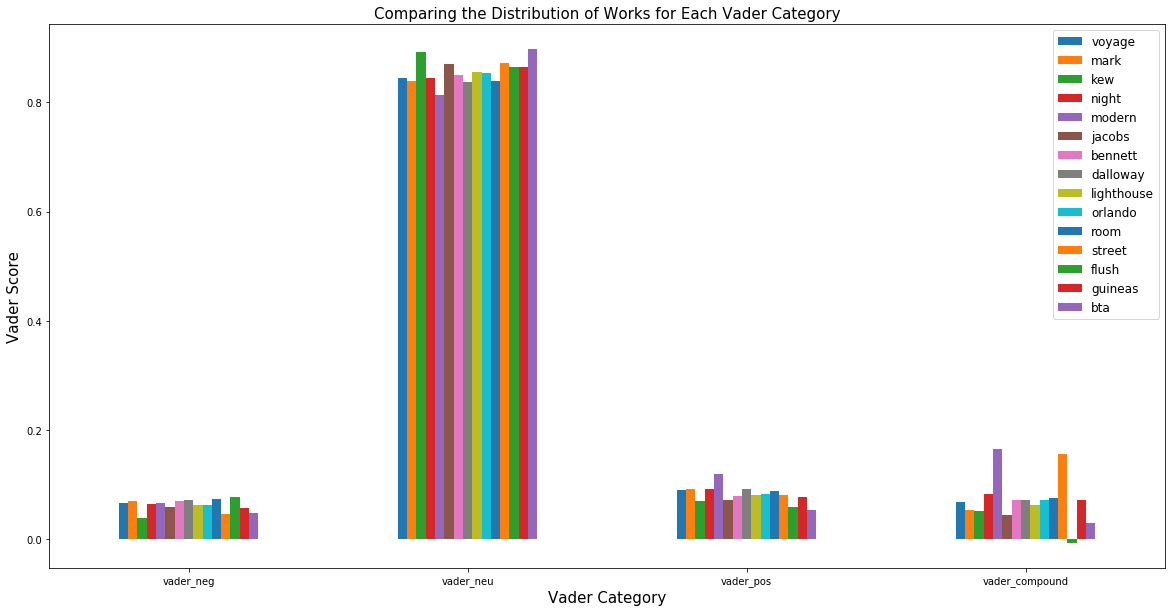

In [89]:
ax = vader_means.plot.bar(rot=0, figsize = (20,10))
ax.legend(fontsize=12)
plt.title("Comparing the Distribution of Works for Each Vader Category", fontsize = 15)
plt.xlabel('Vader Category', fontsize = 15)
plt.ylabel('Vader Score', fontsize = 15)
plt.show()

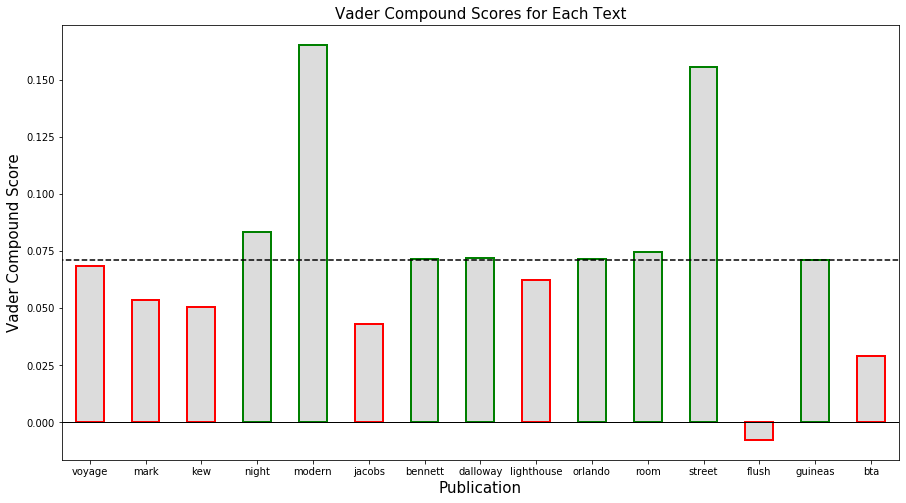

In [90]:
# ordered chronologically
# mean vader compound score for each text
df = vader_means.loc['vader_compound']
mean = df.mean()
ax = df.plot.bar(rot = 0, 
                 figsize = (15, 8), 
                 color = 'gainsboro',
                 ec = ['red', 'red','red', 'green','green','red','green','green', 'red','green','green','green','red','green','red'],
                 linewidth = 2)
ax.hlines(mean, -1, 15, linestyles='dashed')
plt.axhline(linewidth=1, color='black')
plt.title("Vader Compound Scores for Each Text", fontsize = 15)
plt.xlabel('Publication', fontsize = 15)
plt.ylabel('Vader Compound Score', fontsize = 15)
plt.show()

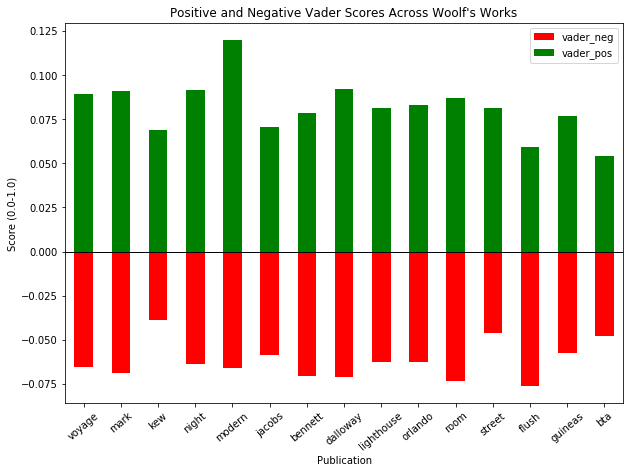

In [91]:
plotdata = vader_means.drop(['vader_neu', 'vader_compound'])
plotdata = plotdata.T
plotdata['vader_neg'] = plotdata['vader_neg']*(-1)
plotdata.plot(kind='bar', stacked=True, color = ['red', 'green'], rot = 40, figsize = (10,7))
plt.title("Positive and Negative Vader Scores Across Woolf's Works")
plt.xlabel("Publication")
plt.ylabel("Score (0.0-1.0)")
plt.axhline(linewidth=1, color='black')
plt.show()

## Woolf's Sentimentality Across Time

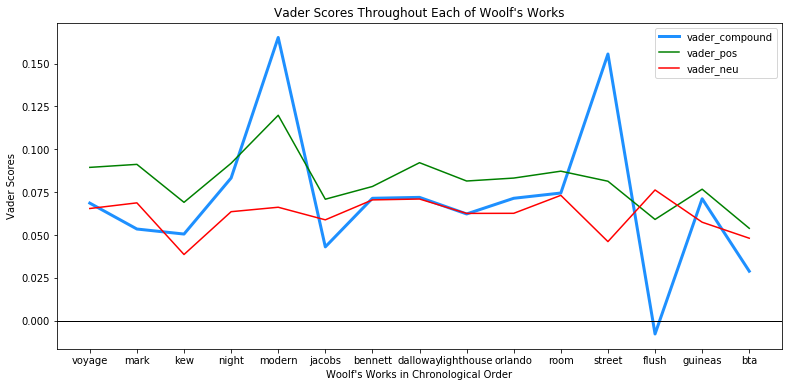

In [92]:
vad_comp = vader_means.loc['vader_compound']
vad_pos = vader_means.loc['vader_pos']
vad_neu = vader_means.loc['vader_neg']

plt.figure(figsize=(13, 6))
plt.plot(vad_comp, label = 'vader_compound', color = 'dodgerblue',linewidth = 3)
plt.plot(vad_pos, label = 'vader_pos', color = 'green', linewidth = 1.5)
plt.plot(vad_neu, label = 'vader_neu', color = 'red', linewidth = 1.5)
plt.axhline(linewidth=1, color='black')
plt.xlabel("Woolf's Works in Chronological Order")
plt.ylabel('Vader Scores')
plt.title("Vader Scores Throughout Each of Woolf's Works")
plt.legend()
plt.show()

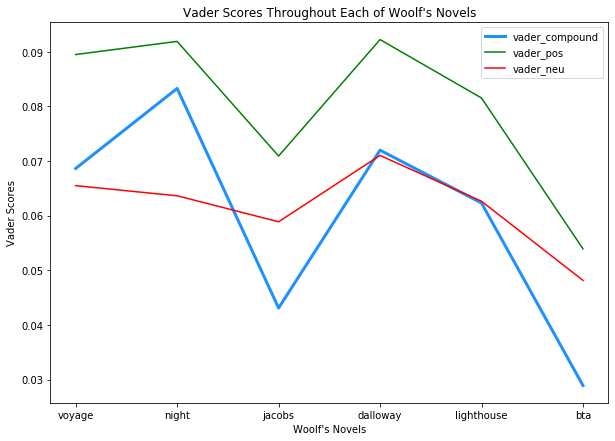

In [93]:
novel_df = vader_means[['voyage', 'night', 'jacobs', 'dalloway', 'lighthouse', 'bta']]
novel_vad_comp = novel_df.loc['vader_compound']
novel_vad_pos = novel_df.loc['vader_pos']
novel_vad_neu = novel_df.loc['vader_neg']

plt.figure(figsize=(10, 7))
plt.plot(novel_vad_comp, label = 'vader_compound', color = 'dodgerblue',linewidth = 3)
plt.plot(novel_vad_pos, label = 'vader_pos', color = 'green',linewidth = 1.5)
plt.plot(novel_vad_neu, label = 'vader_neu', color = 'red',linewidth = 1.5)
plt.xlabel("Woolf's Novels")
plt.ylabel('Vader Scores')
plt.title("Vader Scores Throughout Each of Woolf's Novels")
plt.legend()
plt.show()

Finding the appropropriate amount to group each novel by. Some novels are longer than others, so we have to take larger sets of sentences into each. Say we want 10 points for each.

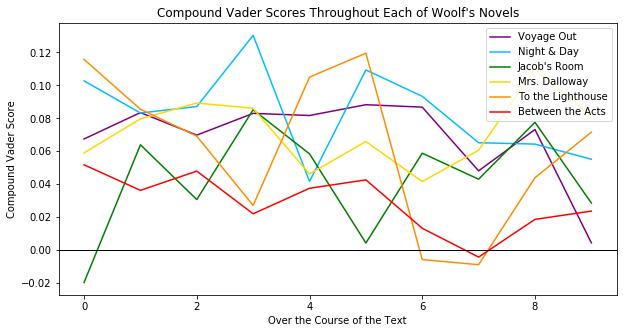

In [104]:
# Vader Compound Chronologically -- Novels

# Voyage Out, 1915
vo = voyage_out_vader['vader_compound']
vo_ave = vo.groupby(np.arange(len(vo))//(len(vo)/10)).mean()
# Night and Day, 1919
nd = night_day_vader['vader_compound']
nd_ave = nd.groupby(np.arange(len(nd))//(len(nd)/10)).mean()
# Jacob's Room, 1922 
jr = jacobs_room_vader['vader_compound']
jr_ave = jr.groupby(np.arange(len(jr))//(len(jr)/10)).mean()
# Mrs. Dalloway, 1925
md = mrs_dalloway_vader['vader_compound']
md_ave = md.groupby(np.arange(len(md))//(len(md)/10)).mean()
# To the Lighthouse, 1927
ttl = to_the_lighthouse_vader['vader_compound']
ttl_ave = ttl.groupby(np.arange(len(ttl))//(len(ttl)/10)).mean()
# Between the Acts, 1941
bta = between_the_acts_vader['vader_compound']
bta_ave = bta.groupby(np.arange(len(bta))//(len(bta)/10)).mean()

plt.figure(figsize=(10, 5))
plt.plot(vo_ave, label = "Voyage Out", color = 'purple')
plt.plot(nd_ave, label = "Night & Day", color = 'deepskyblue')
plt.plot(jr_ave, label = "Jacob's Room", color = 'green')
plt.plot(md_ave, label = "Mrs. Dalloway", color = 'gold')
plt.plot(ttl_ave, label = "To the Lighthouse", color = 'darkorange')
plt.plot(bta_ave, label = "Between the Acts", color = 'red')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score')
plt.axhline(linewidth=1, color='black')
plt.title("Compound Vader Scores Throughout Each of Woolf's Novels")
plt.legend()
plt.show()

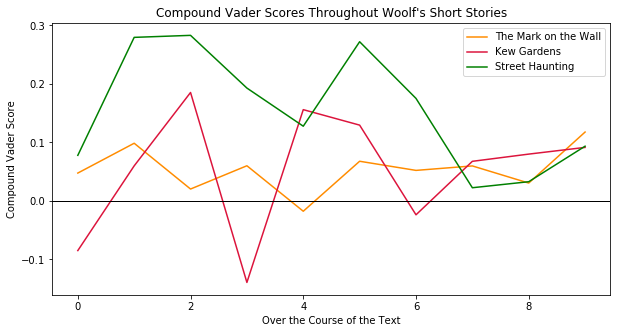

In [105]:
# Vader Compound Chronologically -- Short Stories

# Mark On the Wall, 1917
mw = mark_on_the_wall_vader['vader_compound']
mw_ave = mw.groupby(np.arange(len(mw))//(len(mw)/10)).mean()
# Kew Gardens, 1919 
kw = kew_gardens_vader['vader_compound']
kw_ave = kw.groupby(np.arange(len(kw))//(len(kw)/10)).mean()
# Street Haunting, 1930 
sh = street_haunting_vader['vader_compound']
sh_ave = sh.groupby(np.arange(len(sh))//(len(sh)/10)).mean()

plt.figure(figsize=(10, 5))
plt.plot(mw_ave, label = "The Mark on the Wall", color = 'darkorange')
plt.plot(kw_ave, label = "Kew Gardens", color = 'crimson')
plt.plot(sh_ave, label = "Street Haunting", color = 'green')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score')
plt.title("Compound Vader Scores Throughout Woolf's Short Stories")
plt.axhline(linewidth=1, color='black')
plt.legend()
plt.show()

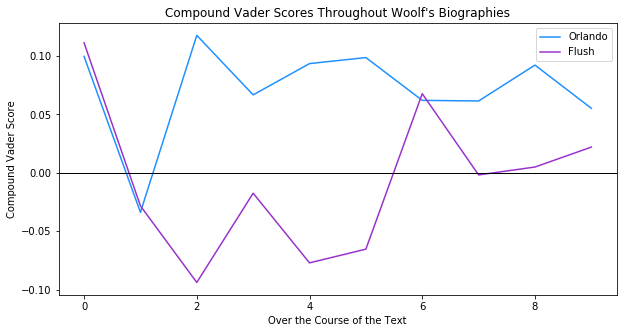

In [107]:
# Vader Compound Chronologically -- Biographies

# Orlando, 1928
orl = orlando_vader['vader_compound']
orl_ave = orl.groupby(np.arange(len(orl))//(len(orl)/10)).mean()
# Flush, 1933
flu = flush_vader['vader_compound']
flu_ave = flu.groupby(np.arange(len(flu))//(len(flu)/10)).mean()

plt.figure(figsize=(10, 5))
plt.plot(orl_ave, label = "Orlando", color = 'dodgerblue')
plt.plot(flu_ave, label = "Flush", color = 'darkorchid')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score')
plt.title("Compound Vader Scores Throughout Woolf's Biographies")
plt.axhline(linewidth=1, color='black')
plt.legend()
plt.show()

This is interesting, that Flush and Orlando are quite opposite of eachother throughout each respective text, with respect to the vader compound scores. According to the graph above, when Orlando is around its peak positivity, at that same point in the text (relative to each text's length, in this case, two tenths into the book) Flush is at its peak negativity. It might be interesting to look at exactly what sentences are the saddest, and the happiest, in these respective biographies. Why do the sentimentalities of these biographies differ so much?

In [122]:
flush_min = flush_vader[flush_vader['vader_compound']==flush_vader['vader_compound'].min()]
print('The saddest sentence in Flush: \n', flush_min.iloc[0]['sentence'])

The saddest sentence in Flush: 
 Thirst was his worst suffering; but one sip of the thick greenish water that stood in a pail near him disgusted him; he would rather die than drink another.


In [123]:
orlando_max = orlando_vader[orlando_vader['vader_compound']==orlando_vader['vader_compound'].max()]
print('\nThe happiest sentence in Orlando: \n', orlando_max.iloc[0]['sentence'])


The happiest sentence in Orlando: 
 For he had sins on his conscience, Mr Dupper was afraid; upon which Mrs Grimsditch would retort, rather sharply, that so had most of us; and Mrs Stewkley and Mrs Field and old Nurse Carpenter would all raise their voices in his Lordship's praise; and the grooms and the stewards would swear that it was a thousand pities to see so fine a nobleman moping about the house when he might be hunting the fox or chasing the deer; and even the little laundry maids and scullery maids, the Judys and the Faiths, who were handing round the tankards and cakes, would pipe up their testimony to his Lordship's gallantry; for never was there a kinder gentleman, or one more free with those little pieces of silver which serve to buy a knot of ribbon or put a posy in one's hair; until even the Blackamoor whom they called Grace Robinson by way of making a Christian woman of her, understood what they were at, and agreed that his Lordship was a handsome, pleasant, darling ge

<span style="color: red;"> [ANALYSIS] </span>  

Comparing the 'happiest', or most positive, and 'saddest', or most negative, sentences for various texts might be useful. For example, how to the 'saddest' sentences in each of Woolf's critical essays compare -- do they all speak of the same topics, critiqueing the same societal downfalls and disappointments? How do the 'happiest' sentences in her short stories compare -- do those all discuss the same serendipitous, beautiful aspects of the human experience? 

Let's make a function that will allow us to look at the most positive, and most negative, sentences of each text; similar to what we did before, but in a function.

In [124]:
def sentence_min(text_vader):
    min_ = text_vader[text_vader['vader_compound']==text_vader['vader_compound'].min()]
    print("The most negative, or 'saddest', sentence: \n", min_.iloc[0]['sentence'])
    
def sentence_max(text_vader):    
    max_ = text_vader[text_vader['vader_compound']==text_vader['vader_compound'].max()]
    print("The most positive, or 'happiest' sentence: \n", max_.iloc[0]['sentence'])

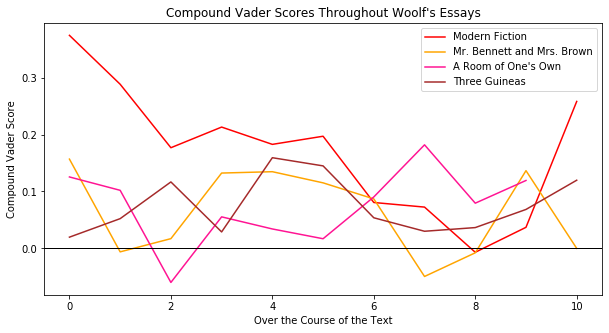

In [125]:
# Vader Compound Chronologically -- Essays

# Modern Fiction, 1921    
mf = modern_fiction_vader['vader_compound']
mf_ave = mf.groupby(np.arange(len(mf))// (len(mf)//10)).mean()
# Mr. Bennett and Mrs. Brown, 1923 
bb = bennett_brown_vader['vader_compound']
bb_ave = bb.groupby(np.arange(len(bb))// (len(bb)//10)).mean()
# A Room of One's Own, 1929 
roo = room_of_ones_own_vader['vader_compound']
roo_ave = roo.groupby(np.arange(len(roo))// (len(roo)//10)).mean()
# Three Guineas, 1938 -
tg = three_guineas_vader['vader_compound']
tg_ave = tg.groupby(np.arange(len(tg))// (len(tg)//10)).mean()

plt.figure(figsize=(10, 5))
plt.plot(mf_ave, label = "Modern Fiction", color = 'red')
plt.plot(bb_ave, label = "Mr. Bennett and Mrs. Brown", color = 'orange')
plt.plot(roo_ave, label = "A Room of One's Own", color = 'deeppink')
plt.plot(tg_ave, label = "Three Guineas", color = 'brown')
plt.axhline(linewidth=1, color='black')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score')
plt.title("Compound Vader Scores Throughout Woolf's Essays")
plt.legend()
plt.show()

In [126]:
# Modern Fiction
sentence_min(modern_fiction_vader)

The most negative, or 'saddest', sentence: 
 On our part, with such a fragment before us, it is hazarded rather than affirmed; but whatever the intention of the whole, there can be no question but that it is of the utmost sincerity and that the result, difficult or unpleasant as we may judge it, is undeniably important.


In [127]:
# Mr. Bennett and Mrs. Brown
sentence_min(bennett_brown_vader)

The most negative, or 'saddest', sentence: 
 And I regret to say that I threw that ugly, that clumsy, that incongruous tool out of the window, for I knew that if I began describing the cancer and the calico, my Mrs. Brown, that vision to which I cling though I know no way of imparting it to you, would have been dulled and tarnished and vanished for ever.


In [128]:
# A Room of One's Own
sentence_min(room_of_ones_own_vader)

The most negative, or 'saddest', sentence: 
 His expression suggested that he was labouring under some emotion that made him jab his pen on the paper as if he were killing some noxious insect as he wrote, but even when he had killed it that did not satisfy him; he must go on killing it; and even so, some cause for anger and irritation remained.


In [130]:
# Three Guineas
sentence_min(three_guineas_vader)

The most negative, or 'saddest', sentence: 
 ) This raises the difficult question whether those who did not aid in the prosecution of the war, but did what they could to hinder the prosecution of the war, ought to use the vote to which they are entitled chiefly because others 'aided in the prosecution of the war'?


**'But she stayed on all through the summer; and when winter wept its damp upon the panes, and choked the gutters with dead leaves, she said: "Why, Bart, did they build the house in the hollow, facing north"?'**

According to the semantic analysis, this sentence is the saddest of the novel. 

**[ANALYSIS]**

**"Since you're interested in pictures," said Bartholomew, turning to the silent guest, "why, tell me, are we, as a race, so incurious, irresponsive and insensitive"--the champagne had given him a flow of unusual three-decker words--"to that noble art, whereas, Mrs. Manresa, if she'll allow me my old man's liberty, has her Shakespeare by heart"?'**

According to the semantic analysis, this sentence is the happiest of the novel. 

#### See why this happens in the documentation

**[ANALYSIS]**

The most negative sentence in Mrs. Dalloway is:<br>
**'He had not cared when Evans was killed; that was worst; but all the other crimes raised their heads and shook their fingers and jeered and sneered over the rail of the bed in the early hours of the morning at the prostrate body which lay realising its degradation; how he had married his wife without loving her; had lied to her; seduced her; outraged Miss Isabel Pole, and was so pocked and marked with vice that women shuddered when they saw him in the street.'**

#### Mostly about septimus

The most positive sentence in Mrs. Dalloway is:<br>
**'Not indeed in actual words; that is, he could not read the language yet; but it was plain enough, this beauty, this exquisite beauty, and tears filled his eyes as he looked at the smoke words languishing and melting in the sky and bestowing upon him in their inexhaustible charity and laughing goodness one shape after another of unimaginable beauty and signalling their intention to provide him, for nothing, for ever, for looking merely, with beauty, more beauty!'**

## Additional Application

### More Analysis
- https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html
- spotify project

In [58]:
# correlation between sentence length and emotion?

In [59]:
import io
import os
from nbformat import current

total_markdown = 0
total_heading = 0
total_code = 0

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".ipynb") and file.startswith("engl3520final_v3"):
            #print(os.path.join(root, file))
            with io.open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                nb = current.read(f, 'json')

            word_count_markdown = 0
            word_count_heading = 0
            word_count_code = 0
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == "markdown":
                    word_count_markdown += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "heading":
                    word_count_heading += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "code":
                    word_count_code += len(cell['input'].replace('#', '').lstrip().split(' '))
            total_markdown += word_count_markdown
            total_heading += word_count_heading
            total_code += word_count_code

print("{} Words in notebooks' markdown" .format(total_markdown))
print("{} Words in notebooks' heading" .format(total_heading))
print("{} Words in notebooks' code" .format(total_code))

5698 Words in notebooks' markdown
28 Words in notebooks' heading
7157 Words in notebooks' code


/opt/anaconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


## Chronological List of Works By Virginia Woolf
https://www.uah.edu/woolf/chrono.html


The Voyage Out (26 March 1915, Duckworth; U.S. pub. by Doran, May 1920)

    Woolf's first novel, begun in 1908 and heavily revised after about 1912.  Manuscript editions of the earlier version (1909-12) have been compiled and published by Louise DeSalvo as Melymbrosia (1982), Woolf's working title for the book.

Two Stories (1917)

     "The Mark on the Wall" by VW and "a story" by Leonard Woolf. The book was published  by subscription only, mainly to friends and acquaintances, and was the Hogarth Press’s first publication.

Kew Gardens (12 May 1919)

     Ten pages of text by VW, with illustrations by her sister, Vanessa Bell.

Night and Day (20 Oct 1919, Duckworth; U.S. pub. Doran, 1920)

     VW considered this her "traditional" novel, in the manner of the nineteenth-century novelists she admired.

Monday or Tuesday (7 April 1921; U.S. pub. Harcourt Brace, Nov. 1921) - stories

     Includes "Kew Gardens," "The Mark on the Wall," "An Unwritten Novel" and five previously  unpublished sketches.

Jacob’s Room (27 Oct 1922; U.S. pub. Harcourt Brace, 1922)

     Her first truly experimental novel and the Hogarth Press’s first large-scale work, Jacob's Room begins Woolf's reputation as "difficult" or "highbrow."  Critics compare her to James Joyce and Dorothy Richardson.  Jacob is based on Woolf's older brother Thoby Stephen, who died of a fever in 1906, when he was in his mid-twenties.

Mr. Bennett and Mrs. Brown (1923)

     A response to Arnold Bennett’s criticism that she "can’t create or didn’t in Jacob’s Room, characters that survive" (Woolf paraphrasing Bennett, Writer’s Diary). First version was published  in the U.S. and then in England. A later, better-known, version was written as a lecture to the Cambridge Heretics on 18 May 1924, then published in the Criterion under the title   "Character in Fiction," and then published by Hogarth Press as Mr. Bennett and Mrs. Brown.   Critically, "the essay became a key document, not only in the assessment of Virginia Woolf’s work, but  in relation to twentieth-century fiction generally" (Critical Heritage 17).

The Common Reader (First Series, 23 Apr 1925)

    The Common Reader was Woolf's title for two series of critical essays she published (the second series was published in 1932), mostly focused on her responses to reading and literature.  It includes biographical sketches of many writers and such now-famous essays as "On Not Knowing Greek" and "How it Strikes a Contemporary."

Mrs. Dalloway (14 May 1925; simultaneously in England  and U.S.; first time for simultaneous publication in U.S. and England)

     A novel that takes place entirely in the space of one day in the life of Clarissa Dalloway, with a parallel plot about a shell-shocked World War I veteran, Septimus Smith.  The setting is London.

To the Lighthouse (5 May 1927)

     Woolf's most famous and most autobiographical novel.   The novel takes place chiefly at a family summer house based on Woolf's own family's house in Cornwall (though the novel is set in the Hebrides), during two visits, seven years apart, with events in between described abstractly in a middle section called "Time Passes."  The "Time Passes" section had been published in French in Dec. 1926.

     See also the original holograph draft / transcribed and edited by Susan Dick
     (Toronto; Buffalo: University of Toronto Press, 1982).
     

Orlando (2 Oct 1928)

      Her most successful novel up to then, in terms of sales (even though publishing it as a "biography" confused booksellers), Orlando traces the life of an English nobleman, Orlando, from the Renaissance to the very moment of publication.  Orlando, based on Woolf's friend Vita Sackville-West, lives 400 years and changes into a woman in the 18th century.

A Room of One’s Own (24 Oct 1929)

    Woolf's first major feminist criticism, originating in two lectures given in October 1928 to students at the two women's colleges of Cambridge University (Newnham and Girton, here fictionalized as "Fernham").  First published as a short essay on "Women and Fiction"  in Forum (March 1929), it was thereafter heavily revised to the present six chapters.

     See also a study of extant manuscripts edited by S.P. Rosenbaum, Virginia Woolf/Women & Fiction: The Manuscript Versions of A Room of One's Own (Oxford : Blackwell, 1992).

The Waves (October 1931)

     This novel is generally considered Woolf's masterpiece, though it is also her most experimental (some say most difficult) work.

    NOTE: The first book-length criticism of VW appeared in 1932, Winifrid Holtby’s biography and Floris Delattre’s Le Roman psychologique de Virginia Woolf. Delattre writes on VW’s use of time (quality vs. quantity).

The Common Reader (Second Series, 1932)

    This collection includes both new and revised critical essays, including biographical sketches of Mary Wollstonecraft and Dorothy Wordsworth, and the now-famous essay "How Should One Read a Book?"

Flush (5 Oct 1933)

     A comic novel written from the point of view of Elizabeth Barrett Browning's cocker spaniel Flush.

The Years (13 March 1937)

     A bestseller, popular with critics and readers, this novel traces the life of a Victorian family, the Pargiters, from 1880 to the "Present Day."  Begun as a sequel to A Room of One's Own, Woolf originally intended to alternate nonfiction essays with the Pargiter's story (which illustrates the essays).  Woolf ultimately extracted the nonfiction and changed the working title from "The Pargiters" to The Years.  Mitchell A. Leaska has edited the extracted portions and published them as The Pargiters: The Novel-Essay Portion of The Years (1977), which also includes the earlier version of the 1880 section of the novel.

Three Guineas (4 June 1938)

     These feminist essays function as a sequel to A Room of One's Own, including a critique of patriarchy (illustrated with photographs of public figures) and an argument for pacifism in the face of the growing threat of another world war.  The  illustrations are not printed in modern editions.

Roger Fry (25 July 1940)

    A biography of Woolf's friend, the art critic and painter (1866-1934), who had introduced post-impressionism (Picasso, Cezanne) to England in the years before World War I.  

Between the Acts (17 July 1941)

    Woolf's last novel, published after her death.  She had changed her mind about publishing it just days before her death (see letter to John Lehmann).   Like Mrs. Dalloway, the action takes place in a short span of time in June and is focused on a social event, here a community pageant rather than a party.  The setting is June 1939  in the English countryside at a house called Pointz Hall (the working title of the book), home of the Olivers, and in the nearby village, where Miss LaTrobe is in charge of the pageant.   The pageant concerns English history, and parts of it are part of the narrative. 

In [60]:
# DIFFERENT METHOD
# vo = voyage_out_vader['vader_compound']
# vo_ave = ((vo + vo.shift(-1)) / 280)[::280]
# nd = night_day_vader['vader_compound']
# nd_ave = ((nd + nd.shift(-1)) / 310)[::310]
# jr = jacobs_room_vader['vader_compound']
# jr_ave = ((jr + jr.shift(-1)) / 115)[::115]
# md = mrs_dalloway_vader['vader_compound']
# md_ave = ((md + md.shift(-1)) / 123)[::123]
# ttl = to_the_lighthouse_vader['vader_compound']
# ttl_ave = ((ttl + ttl.shift(-1)) / 117)[::117]
# bta = between_the_acts_vader['vader_compound']
# bta_ave = ((bta + bta.shift(-1)) / 148)[::148]

# plt.figure(figsize=(20, 10))
# plt.plot(vo_ave, label = "Voyage Out", color = 'purple')
# plt.plot(nd_ave, label = "Night & Day", color = 'blue')
# plt.plot(jr_ave, label = "Jacob's Room", color = 'green')
# plt.plot(md_ave, label = "Mrs. Dalloway", color = 'brown')
# plt.plot(ttl_ave, label = "To the Lighthouse", color = 'orange')
# plt.plot(bta_ave, label = "Between the Acts", color = 'red')
# plt.xlabel('Course of the Novel')
# plt.ylabel('Vader Compound Score')
# plt.title('Compound Vader Scores Throughout the Novels')
# plt.legend()